This notebook is the implementation of the Recurrent Neural Network for stock prediction. We use Tushare API for scraping and developing our dataset. To make the training process easier and shorter. We chose to train on a single stock dataset 000001.SZ, which holds about 3000 days of stock data from January 1st, 2010 to December 31th, 2022. The Cnn is consists of  two convolution layers, two relu activation functions, a maximum pooling layer, and a full connection layer. 

We use 10 day stocks as a group, arrange them in order, and then pass through the convolutional neural network. The 2 convolution layers has a 1*10 kernel size, produce 3 groups data, The kernel scans the stock groups in turn to get the filtered data. then the data would be transformed into the second convolution layer which has a 1*3 kernel size. Then the selected data would pass a maxpool whose size is 1*2, finally the predict data would be calculated through the full connection layer.

# G52 Project --- CNN predicts the stock price

Import data API

In [1]:
import tushare as ts
import numpy as np
import torch
import torch.nn as nn
import math
import time
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt


Use set_token() to obtain the data token.<br>
ts_code represents the stock code, people could change it to convert to any other stock.<br>
open represents the opening price. <br>
high represents the highest price in a day. <br>
low represents the lowest price in a day. <br>
close represents the closed price in a day. <br>
pre_close represents the pre_closed price in a day. <br>
change represents the rise and decline in a day.<br>
pct_chg represents the precents of the change in a day.<br>
vol represents the trading volume. <br>
amount represents the transaction volume.

In [2]:
ts.set_token('293d683e83b36fad82472d9a4b4c3903d21fa6bcb85cb0cd4f4b9414')
pro = ts.pro_api()
df = pro.daily(ts_code='000001.SZ', start_date='2010-01-01', end_date='2022-12-31')

df.head()

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,000001.SZ,20211118,18.09,18.12,17.73,17.80,18.11,-0.31,-1.7118,799843.77,1430058.311
1,000001.SZ,20211117,18.15,18.30,17.98,18.11,18.22,-0.11,-0.6037,664640.38,1203859.180
2,000001.SZ,20211116,18.36,18.54,18.17,18.22,18.43,-0.21,-1.1394,601110.48,1099113.409
3,000001.SZ,20211115,18.35,18.63,18.20,18.43,18.27,0.16,0.8758,655089.99,1203764.095
4,000001.SZ,20211112,18.31,18.63,18.11,18.27,18.35,-0.08,-0.4360,957546.46,1753072.716


Data Preprossing:<br>
Turn the data in chronological order, and put the latest data in the back. The data downloaded from tushare is the latest in the front, so it is convenient to prepare X and y data in the back. <br>
Then normalize the data in order to avoid too large or small real data affecting the judgment of the model and split the data fot the training.

In [3]:
#Turn the data in chronological order
df = df.iloc[::-1]
df.reset_index(inplace=True)

#Only use the data of the closing price field in the data
training_set = df.loc[:, ['close']]
#print(training_set)
#Only take price data, not header and other contents
training_set = training_set.values
#print(training_set)
#Regularize the data and convert them into data between 0 and 1
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

'''
First use the closing price of the latest trading day as the first y, and then use the closing price of 60 
trading days before this trading day as X (for training).
'''
x_train = []
y_train = []
for i in range(10, len(training_set_scaled)):
    x_train.append(training_set_scaled[i-10:i])
    y_train.append(training_set_scaled[i, training_set_scaled.shape[1] - 1])
x, y = np.array(x_train), np.array(y_train)




With or without GPU?

In [4]:
device= torch.device("cpu")
print(device)

cpu


Divide training set and test set.

In [5]:
x_train = x[:2000]
y_train = y[:2000]

x_test = x[2000:]
y_test = y[2000:]

print(f"x_train size: {len(x_train)}")
print(f"y_train size: {len(y_train)}")
print(f"x_test size: {len(x_test)}")
print(f"y_test size: {len(y_test)}")
test_size = len(x_test)

torch.Tensor(x_train).size()

x_train size: 2000
y_train size: 2000
x_test size: 806
y_test size: 806


torch.Size([2000, 10, 1])

Construct the network, this network consists of:<br>
2 convolution layers<br>
2 relu activation functions<br>
1 maximum pooling layer <br>
1 full connection layer

In [6]:
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, BatchNorm2d, Dropout, Sigmoid

class CNNpred(nn.Module):
    def __init__(self, num_features, num_filter, drop):
        super(CNNpred, self).__init__()

        self.conv1 = Conv2d(1, num_filter, kernel_size=(1, num_features))
        self.relu1 = ReLU()
        self.conv2 = Conv2d(num_filter, num_filter, kernel_size=(1, 3))
        self.relu2 = ReLU()
        self.pool1 = MaxPool2d(kernel_size=(1, 2))
        self.drop1 = Dropout(drop)
        self.fc1 = Linear(30, 1)

    # Defining the forward pass    
    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.pool1(x)
        x =  self.drop1(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)

        return x

Display how many parameters in the net

In [7]:
net = CNNpred(3, 10, 0.02)

print(net.conv1.weight.size())


torch.Size([10, 1, 1, 3])


Organize the data so that the dimension of the data set can adapt to the parameters of the neural network.

In [8]:
train_data = torch.Tensor(x_train).unsqueeze(0)
# print(train_data)

train_data = train_data.permute(1, 0, 3, 2)

print(train_data.size())

train_label = torch.Tensor(y_train)

print(train_label.size())

test_data = torch.Tensor(x_test).unsqueeze(0)

test_data = test_data.permute(1, 0, 3, 2)
print(test_data.size())
test_label = torch.Tensor(y_test)

x_train[0].shape

x_train.shape

bs = 1

hidden_size=300


net = net.to(device)


torch.Size([2000, 1, 1, 10])
torch.Size([2000])
torch.Size([806, 1, 1, 10])


Choose the criterion, batch size, and initial learning rate

In [9]:
criterion = nn.MSELoss()
my_lr=0.3
bs= 1


Do 20 passes through the training set. Divide the learning rate by 2 at epoch 10, 14 and 18.

In [10]:
start=time.time()

# shuffle_indices = torch.randperm(2000)

for epoch in range(1,15):
    
    # divide the learning rate by 2 at epoch 10, 14 and 18
    if epoch==10 or epoch == 14 or epoch==18:
        my_lr = my_lr / 2
    
    # create a new optimizer at the beginning of each epoch: give the current learning rate.   
    optimizer=torch.optim.SGD( net.parameters() , lr=my_lr )
        
    # set the running quatities to zero at the beginning of the epoch
    running_loss=0
    running_error=0
    num_batches=0
    
    # set the order in which to visit the image from the training set
    shuffled_indices=torch.randperm(2000)
 
    for count in range(0,2000,bs):
    
        # Set the gradients to zeros
        optimizer.zero_grad()
        
        # create a minibatch       
        indices=shuffled_indices[count:count+bs]
        minibatch_data =  train_data[indices]
        minibatch_label=  train_label[indices]
        
        # send them to the gpu
        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        inputs = minibatch_data
        
        # tell Pytorch to start tracking all operations that will be done on "inputs"
        inputs.requires_grad_()

        # forward the minibatch through the net 
        scores=net( inputs ) 

        # Compute the average of the losses of the data points in the minibatch
        loss =  criterion( scores , minibatch_label) 
                
        # backward pass to compute dL/dU, dL/dV and dL/dW   
        loss.backward()

        # do one step of stochastic gradient descent: U=U-lr(dL/dU), V=V-lr(dL/dU), ...
        optimizer.step()
        

        # START COMPUTING STATS
        
        # add the loss of this batch to the running loss
        running_loss += loss.detach().item()
               
        num_batches+=1        
    
    
    # compute stats for the full training set
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    elapsed = (time.time()-start)/60
    

    print('epoch=',epoch, '\t time=', elapsed,'min','\t lr=', my_lr  ,'\t loss=', total_loss)
#     eval_on_test_set() 
    print(' ')
    
           

/Users/chrislee/miniconda3/envs/deeplearn_course1/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1623459064158/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/Users/chrislee/miniconda3/envs/deeplearn_course1/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch= 1 	 time= 0.02480851411819458 min 	 lr= 0.3 	 loss= 0.02355139276879133
 
epoch= 2 	 time= 0.04620142777760824 min 	 lr= 0.3 	 loss= 0.016387573614065277
 
epoch= 3 	 time= 0.07292269468307495 min 	 lr= 0.3 	 loss= 0.016560865157151945
 
epoch= 4 	 time= 0.09926334619522095 min 	 lr= 0.3 	 loss= 0.021665384360601708
 
epoch= 5 	 time= 0.12148601611455281 min 	 lr= 0.3 	 loss= 0.021707861998501277
 
epoch= 6 	 time= 0.14279464880625406 min 	 lr= 0.3 	 loss= 0.021183214660506374
 
epoch= 7 	 time= 0.16706544558207195 min 	 lr= 0.3 	 loss= 0.02110321890250011
 
epoch= 8 	 time= 0.19162554740905763 min 	 lr= 0.3 	 loss= 0.020281385687111665
 
epoch= 9 	 time= 0.2141019622484843 min 	 lr= 0.3 	 loss= 0.020584380726256846
 
epoch= 10 	 time= 0.2439003825187683 min 	 lr= 0.15 	 loss= 0.0063408010689079515
 
epoch= 11 	 time= 0.27308443387349446 min 	 lr= 0.15 	 loss= 0.00602520710767404
 
epoch= 12 	 time= 0.29826311667760214 min 	 lr= 0.15 	 loss= 0.005393950378297374
 
epoch= 13 	 ti

Function to evaluate the network on the test set <br>
Convert the results in the test set into normal values (regularized the data in the data preprocessing)

In [11]:
predict = []

def eval_on_test_set():
    running_loss=0
    num_batches=0
    
    for i in range(0,len(test_data),bs):
        #print(i)
        minibatch_data =  test_data[i:i+bs]
        minibatch_label= test_label[i:i+bs]

        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        #minibatch_data = (minibatch_data - test_data.mean())/test_data.std()
        scores=net( minibatch_data ) 
        #print(scores)
        scores = scores.view(1,1)
        #print(scores)
        scores = scores.detach().numpy()
        #print(scores)
        scores = sc.inverse_transform(scores)
        #print(scores)
        predict.append(scores[0][0]) 
        
        running_loss += loss.detach().item()

        num_batches+=1

#     total_error = running_error/num_batches
    print( 'total loss =', running_loss )

In [12]:
eval_on_test_set()

total loss = 0.9740191956516355


Plot the final result.<br>
you can see that the two curves, namely the predictions from the model and its true labels has the same trends in general, so the model is still generalizable for predicting whether the stock will increase the value of decrease.

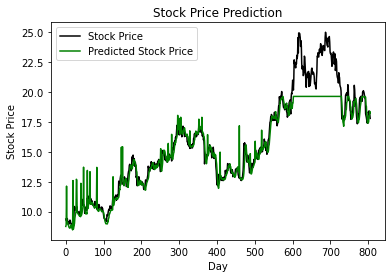

In [13]:
plt.plot(sc.inverse_transform(test_label.view(test_size,1)), color = 'black', label = 'Stock Price')
plt.plot(predict, color = 'green', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Day')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [14]:
test_label_1 = []
for i in torch.tensor(sc.inverse_transform(test_label.view(806,1))[-9:]).view(1,9).numpy().tolist()[0]:
    print(i)
    test_label_1.append(i)
test_label_1.append(predict[-1])
print([test_label_1][0:1])

17.420000479221347
17.530000174045565
17.399999732971192
18.35000039339066
18.270000348091127
18.43000043869019
18.219999952316286
18.110000257492068
17.799999959468845
[[17.420000479221347, 17.530000174045565, 17.399999732971192, 18.35000039339066, 18.270000348091127, 18.43000043869019, 18.219999952316286, 18.110000257492068, 17.799999959468845, 18.243496]]


In [15]:
# predict = test_label_1
for i in range(0,len(test_label_1)):
    test_ = torch.tensor([test_label_1[i:i+10]]).unsqueeze(0).unsqueeze(0)
    test_ = test_.to(device)
    print(test_.size())
    scores  = net(test_)
    scores = scores.view(1,1)
    print(scores)
    scores = scores.detach().numpy()
    test_label_1.append(scores[0][0])

torch.Size([1, 1, 1, 10])
tensor([[0.0196]], grad_fn=<ViewBackward>)
torch.Size([1, 1, 1, 10])
tensor([[0.0571]], grad_fn=<ViewBackward>)
torch.Size([1, 1, 1, 10])
tensor([[-1.4908]], grad_fn=<ViewBackward>)
torch.Size([1, 1, 1, 10])
tensor([[-1.6331]], grad_fn=<ViewBackward>)
torch.Size([1, 1, 1, 10])
tensor([[-4.1038]], grad_fn=<ViewBackward>)
torch.Size([1, 1, 1, 10])
tensor([[-4.0818]], grad_fn=<ViewBackward>)
torch.Size([1, 1, 1, 10])
tensor([[-3.6785]], grad_fn=<ViewBackward>)
torch.Size([1, 1, 1, 10])
tensor([[-2.9101]], grad_fn=<ViewBackward>)
torch.Size([1, 1, 1, 10])
tensor([[-1.3176]], grad_fn=<ViewBackward>)
torch.Size([1, 1, 1, 10])
tensor([[-0.9440]], grad_fn=<ViewBackward>)


In [16]:
day = []
for i in range(len(test_label_1)-10):
        day.append(test_size+1+i)

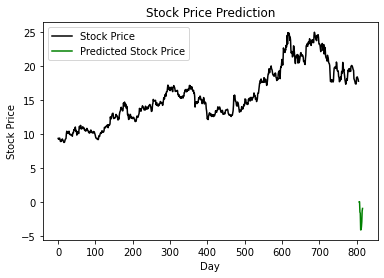

In [17]:
plt.plot(sc.inverse_transform(test_label.view(test_size,1)), color = 'black', label = 'Stock Price')
plt.plot(day,test_label_1[10:], color = 'green', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Day')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [18]:
def get_error( scores , labels ):
    bs=len(scores)
    matches = 0.0    
    for i in range (len(scores)):
        if abs(scores[i] - labels[i]) <=1.5:
            matches+=1   
    return matches/bs

In [19]:
get_error(predict , sc.inverse_transform(test_label.view(test_size,1)) )

0.8337468982630273

# Analysis

Generally,In the final result, the accuracy is 87%, but it fits the trends of the real-stock price in some extends. Considering the CNN is designed for the image recognition rather than data prediction, so we think the result is great.